<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# Desafío 4 - Traductor Seq2Seq con PyTorch
## Modelo Encoder-Decoder LSTM para Traducción Inglés-Español

### Objetivos del Desafío

1. **Replicar el modelo en PyTorch** siguiendo la arquitectura del notebook de referencia (6c - traductor.ipynb)
2. **Extender el entrenamiento** a más datos y tamaños de secuencias mayores que el modelo de referencia
3. **Explorar el impacto** de la cantidad de neuronas en las capas recurrentes (comparar LSTM-64, LSTM-128, LSTM-256)
4. **Mostrar 5 ejemplos** de traducciones generadas por cada modelo

### Extensiones Implementadas

- **Más datos**: 15,000 muestras vs 6,000 del original
- **Secuencias más largas**: 20/22 tokens vs 16/18 del original
- **Comparación de arquitecturas**: LSTM-64, LSTM-128, LSTM-256
- **Optimización de memoria**: One-hot encoding bajo demanda
- **Early stopping mejorado**: Patience adaptativo según tamaño del modelo

## 1. Instalación de Dependencias

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet
!pip install torchinfo --quiet

In [2]:
import re
import os
import pickle
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.rcParams['figure.figsize'] = (14, 6)
sns.set_style('whitegrid')

# Verificar disponibilidad de GPU
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
print(f"Dispositivo: {device}")
print(f"PyTorch version: {torch.__version__}")

Dispositivo: cpu
PyTorch version: 2.7.1+cpu


## 2. Descarga de Helpers

In [3]:
import platform

if not os.path.exists('torch_helpers.py'):
    print("Descargando torch_helpers.py...")
    if platform.system() == 'Windows':
        !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget -O torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
else:
    print("torch_helpers.py ya existe")

torch_helpers.py ya existe


In [4]:
from torch_helpers import Tokenizer, pad_sequences

## 3. Funciones de Entrenamiento y Evaluación

In [5]:
def sequence_acc(y_pred, y_test):
    """Calcula accuracy a nivel de secuencia (del modelo de referencia)"""
    y_pred_tag = y_pred.data.max(dim=-1, keepdim=True)[1]
    y_test_tag = y_test.data.max(dim=-1, keepdim=True)[1]

    batch_size = y_pred_tag.shape[0]
    batch_acc = torch.zeros(batch_size)
    for b in range(batch_size):
        correct_results_sum = (y_pred_tag[b] == y_test_tag[b]).sum().float()
        batch_acc[b] = correct_results_sum / y_pred_tag[b].shape[0]

    correct_results_sum = batch_acc.sum().float()
    acc = correct_results_sum / batch_size
    return acc


def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100, patience=5, model_name='model'):
    """Función de entrenamiento con early stopping mejorado"""
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    save_path = f'best_translator_{model_name}.pth'

    for epoch in range(epochs):
        # Training
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            optimizer.zero_grad()

            output = model(train_encoder_input.to(device), train_decoder_input.to(device))

            # Calcular loss por cada token
            loss = 0
            for t in range(train_decoder_input.shape[1]):
                loss += criterion(output[:, t, :], train_target[:, t, :])

            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            # Calcular accuracy
            accuracy = sequence_acc(output, train_target)
            epoch_train_accuracy += accuracy.item()

        # Promedios de época
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Validation
        valid_encoder_input, valid_decoder_input, valid_target = next(iter(valid_loader))
        output = model(valid_encoder_input.to(device), valid_decoder_input.to(device))
        
        epoch_valid_loss = 0
        for t in range(train_decoder_input.shape[1]):
            epoch_valid_loss += criterion(output[:, t, :], valid_target[:, t, :])
        epoch_valid_loss = epoch_valid_loss.item()
        valid_loss.append(epoch_valid_loss)

        epoch_valid_accuracy = sequence_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train acc {epoch_train_accuracy:.3f} - Val loss {epoch_valid_loss:.3f} - Val acc {epoch_valid_accuracy:.3f}")
        
        # Early stopping
        if epoch_valid_loss < best_val_loss:
            best_val_loss = epoch_valid_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"  ✓ Modelo guardado: {save_path}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping en época {epoch+1}")
                break

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

## 4. Descarga y Carga del Dataset

Utilizaremos el dataset de traducciones inglés-español de Anki.

**EXTENSIÓN 1: Más datos**  
El notebook de referencia usa 6,000 muestras. Aquí usaremos 15,000 para mejorar la generalización.

In [6]:
import gdown

if not os.path.exists('spa-eng'):
    if not os.path.exists('spa-eng.zip'):
        print("Descargando dataset...")
        url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
        output = 'spa-eng.zip'
        gdown.download(url, output, quiet=False)
    print("Extrayendo dataset...")
    !unzip -q spa-eng.zip
else:
    print("Dataset ya descargado")

Dataset ya descargado


In [7]:
# EXTENSIÓN: Usar 15k muestras (vs 6k del original)
MAX_NUM_SENTENCES = 15000

text_file = "./spa-eng/spa.txt"
with open(text_file, encoding='utf-8') as f:
    lines = f.read().split("\n")[:-1]

print(f"Cantidad de filas disponibles: {len(lines):,}")
print(f"Usando: {MAX_NUM_SENTENCES:,} (vs 6,000 del modelo de referencia)")

# Mezclar dataset (misma semilla que el original)
np.random.seed(40)
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []

for line in lines[:MAX_NUM_SENTENCES]:
    if '\t' not in line:
        continue

    # Input sentence --> eng, output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # decoder_output tiene <eos>
    output_sentence = output + ' <eos>'
    # decoder_input tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print(f"Cantidad procesada: {len(input_sentences):,}")
print(f"\nEjemplo:")
print(f"  Inglés: {input_sentences[0]}")
print(f"  Español: {output_sentences[0]}")

Cantidad de filas disponibles: 118,964
Usando: 15,000 (vs 6,000 del modelo de referencia)
Cantidad procesada: 15,000

Ejemplo:
  Inglés: Somebody stole my car.
  Español: Alguien robó mi auto. <eos>


## 5. Tokenización y Preprocesamiento

In [8]:
# Tamaño máximo de vocabulario
MAX_VOCAB_SIZE = 8000

# Tokenizer para inglés (input)
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print(f"Palabras en vocabulario inglés: {len(word2idx_inputs):,}")

max_input_len_full = max(len(sen) for sen in input_integer_seq)
print(f"Sentencia de entrada más larga: {max_input_len_full}")

Palabras en vocabulario inglés: 6,004
Sentencia de entrada más larga: 34


In [9]:
# Tokenizer para español (output)
# Sacar "<>" de los filtros para no afectar tokens especiales
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print(f"Palabras en vocabulario español: {len(word2idx_outputs):,}")

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
max_out_len_full = max(len(sen) for sen in output_integer_seq)
print(f"Sentencia de salida más larga: {max_out_len_full}")

Palabras en vocabulario español: 9,724
Sentencia de salida más larga: 38


**EXTENSIÓN 2: Secuencias más largas**

El modelo de referencia usa max_input_len=16 y max_out_len=18.  
Aquí usaremos 20 y 22 para capturar más contexto.

In [10]:
# EXTENSIÓN: Secuencias más largas
max_input_len = 20   # Original: 16
max_out_len = 22     # Original: 18

print(f"Longitudes configuradas:")
print(f"  Entrada (inglés):  {max_input_len} tokens (vs 16 del original)")
print(f"  Salida (español):  {max_out_len} tokens (vs 18 del original)")

Longitudes configuradas:
  Entrada (inglés):  20 tokens (vs 16 del original)
  Salida (español):  22 tokens (vs 18 del original)


In [11]:
# Aplicar padding
# IMPORTANTE: encoder con padding='pre', decoder con padding='post'
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len, padding='pre')
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

print(f"Shapes finales:")
print(f"  encoder_input_sequences: {encoder_input_sequences.shape}")
print(f"  decoder_input_sequences: {decoder_input_sequences.shape}")
print(f"  decoder_output_sequences: {decoder_output_sequences.shape}")

Shapes finales:
  encoder_input_sequences: (15000, 20)
  decoder_input_sequences: (15000, 22)
  decoder_output_sequences: (15000, 22)


## 6. Preparación de Embeddings (GloVe)

In [12]:
# Descargar embeddings GloVe
if not os.path.exists('gloveembedding.pkl'):
    print("Descargando embeddings GloVe...")
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Embeddings ya descargados")

Embeddings ya descargados


In [13]:
import logging

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        words_embedding_pkl = Path(self.PKL_PATH)
        assert words_embedding_pkl.is_file(), f'Embeddings no encontrados: {self.PKL_PATH}'
        embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        
        index = np.arange(self.embeddings.shape[0])
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        if isinstance(words, str):
            words = [words]
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        max_bytes = 2**28 - 1
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


# Cargar embeddings
model_embeddings = GloveEmbeddings()
embed_dim = model_embeddings.N_FEATURES
print(f"Dimensión de embeddings: {embed_dim}")

Dimensión de embeddings: 50


In [14]:
# Crear matriz de embeddings para inglés
print('Preparando embedding matrix...')
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs))
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

print(f'Palabras sin embedding: {np.sum(np.sum(embedding_matrix, axis=1) == 0)}')
print(f'Shape: {embedding_matrix.shape}')

Preparando embedding matrix...
Palabras sin embedding: 257
Shape: (6004, 50)


## 7. Dataset de PyTorch

Crear dataset optimizado con one-hot encoding bajo demanda (ahorra ~21GB de RAM).

In [15]:
class TranslationDataset(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output, num_classes):
        # Guardar como tensores int32 (liviano)
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        self.decoder_outputs_int = torch.from_numpy(decoder_output.astype(np.int32)).to(torch.int64)
        
        self.num_classes = num_classes
        self.len = self.encoder_inputs.shape[0]

    def __getitem__(self, index):
        # One-hot encoding se crea solo cuando se solicita (ahorra RAM)
        decoder_output_onehot = F.one_hot(
            self.decoder_outputs_int[index], 
            num_classes=self.num_classes
        ).float()
        
        return (
            self.encoder_inputs[index], 
            self.decoder_inputs[index], 
            decoder_output_onehot
        )

    def __len__(self):
        return self.len


# Crear dataset
dataset = TranslationDataset(
    encoder_input_sequences, 
    decoder_input_sequences, 
    decoder_output_sequences,
    num_words_output
)

print(f"Dataset creado: {len(dataset):,} muestras")
print(f"Output dim: {num_words_output} clases")

Dataset creado: 15,000 muestras
Output dim: 8000 clases


In [16]:
# Split train/valid
torch.manual_seed(42)
valid_size = int(len(dataset) * 0.2)
train_size = len(dataset) - valid_size

train_set = torch.utils.data.Subset(dataset, range(train_size))
valid_set = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

print(f"Train set: {len(train_set):,}")
print(f"Valid set: {len(valid_set):,}")

# DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)

Train set: 12,000
Valid set: 3,000


## 8. Arquitectura del Modelo Seq2Seq

Basado en el modelo de referencia (6c - traductor.ipynb) con corrección crítica:
- **Eliminado Softmax del Decoder** (CrossEntropyLoss ya lo incluye internamente)

In [17]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, lstm_size=128, num_layers=1):
        super().__init__()
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.embedding_dim = embedding_matrix.shape[1]
        
        # Embedding con pesos pre-entrenados (GloVe)
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, 
            embedding_dim=self.embedding_dim, 
            padding_idx=0
        )
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # Freeze
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim, 
            hidden_size=self.lstm_size, 
            batch_first=True,
            num_layers=self.num_layers
        )

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)


class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim, lstm_size=128, num_layers=1, embed_dim=50):
        super().__init__()
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        # Embedding (no pre-entrenado para español)
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, 
            embedding_dim=self.embedding_dim, 
            padding_idx=0
        )
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim, 
            hidden_size=self.lstm_size, 
            batch_first=True,
            num_layers=self.num_layers
        )
        
        # Fully connected - CORREGIDO: sin Softmax
        # CrossEntropyLoss ya aplica softmax internamente
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim)

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # Retornar logits crudos (sin softmax)
        out = self.fc1(lstm_output[:, -1, :])
        return out, (ht, ct)


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions debe ser igual"
        assert encoder.num_layers == decoder.num_layers, \
            "Número de capas debe ser igual"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        # Tensor para almacenar outputs
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)
        if cuda:
            outputs = outputs.cuda()
        
        # Hidden state del encoder → decoder
        prev_state = self.encoder(encoder_input)
        
        # Loop de decodificación con teacher forcing
        for t in range(decoder_input_len):
            input_token = decoder_input[:, t:t+1]
            output, prev_state = self.decoder(input_token, prev_state)
            outputs[:, t, :] = output
        
        return outputs


def create_model(lstm_size=128, num_layers=1):
    encoder = Encoder(
        vocab_size=nb_words, 
        embedding_matrix=embedding_matrix,
        lstm_size=lstm_size,
        num_layers=num_layers
    )
    
    decoder = Decoder(
        vocab_size=num_words_output, 
        output_dim=num_words_output,
        lstm_size=lstm_size,
        num_layers=num_layers,
        embed_dim=embed_dim
    )
    
    model = Seq2Seq(encoder, decoder)
    
    if cuda:
        model.cuda()
    
    return model


print("Arquitectura definida")

Arquitectura definida


## 9. Entrenamiento de Modelos

**EXTENSIÓN 3: Explorar el impacto de la cantidad de neuronas**

Entrenaremos 3 modelos con diferentes tamaños de LSTM:
- LSTM-64: Más rápido, menor capacidad
- LSTM-128: Balance (como el modelo de referencia)
- LSTM-256: Mayor capacidad, más lento

In [18]:
# Configuración de entrenamiento
EPOCHS = 20
LEARNING_RATE = 0.001  # LR optimizado para Adam
PATIENCE = 5

print("Configuración:")
print(f"  Épocas: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Patience: {PATIENCE}")
print(f"  Batch size: {BATCH_SIZE}")

Configuración:
  Épocas: 20
  Learning rate: 0.001
  Patience: 5
  Batch size: 32


### 9.1. Modelo LSTM-64

In [19]:
print("=" * 80)
print("ENTRENANDO MODELO LSTM-64")
print("=" * 80)

# Crear modelo
model_64 = create_model(lstm_size=64)
optimizer_64 = torch.optim.Adam(model_64.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

# Resumen
sample_batch = next(iter(train_loader))
print("\nArquitectura:")
summary(model_64, input_data=(sample_batch[0][:1], sample_batch[1][:1]))

print("\nEntrenando...\n")

# Entrenar
history_64 = train(
    model_64,
    train_loader,
    valid_loader,
    optimizer_64,
    criterion,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name='lstm64'
)

print("\n✓ LSTM-64 completado\n")

ENTRENANDO MODELO LSTM-64

Arquitectura:

Entrenando...

Epoch 1/20 - Train loss 60.971 - Train acc 0.679 - Val loss 38.593 - Val acc 0.737
  ✓ Modelo guardado: best_translator_lstm64.pth
Epoch 2/20 - Train loss 40.726 - Train acc 0.731 - Val loss 35.915 - Val acc 0.756
  ✓ Modelo guardado: best_translator_lstm64.pth
Epoch 3/20 - Train loss 38.018 - Train acc 0.746 - Val loss 34.540 - Val acc 0.761
  ✓ Modelo guardado: best_translator_lstm64.pth
Epoch 4/20 - Train loss 35.940 - Train acc 0.754 - Val loss 33.252 - Val acc 0.764
  ✓ Modelo guardado: best_translator_lstm64.pth
Epoch 5/20 - Train loss 34.171 - Train acc 0.759 - Val loss 32.182 - Val acc 0.767
  ✓ Modelo guardado: best_translator_lstm64.pth
Epoch 6/20 - Train loss 32.597 - Train acc 0.765 - Val loss 31.509 - Val acc 0.770
  ✓ Modelo guardado: best_translator_lstm64.pth
Epoch 7/20 - Train loss 31.189 - Train acc 0.769 - Val loss 30.739 - Val acc 0.770
  ✓ Modelo guardado: best_translator_lstm64.pth
Epoch 8/20 - Train loss 29

### 9.2. Modelo LSTM-128

In [20]:
print("=" * 80)
print("ENTRENANDO MODELO LSTM-128")
print("=" * 80)

# Crear modelo
model_128 = create_model(lstm_size=128)
optimizer_128 = torch.optim.Adam(model_128.parameters(), lr=LEARNING_RATE)

print("\nEntrenando...\n")

# Entrenar
history_128 = train(
    model_128,
    train_loader,
    valid_loader,
    optimizer_128,
    criterion,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name='lstm128'
)

print("\n✓ LSTM-128 completado\n")

ENTRENANDO MODELO LSTM-128

Entrenando...



Epoch 1/20 - Train loss 53.864 - Train acc 0.693 - Val loss 37.025 - Val acc 0.749
  ✓ Modelo guardado: best_translator_lstm128.pth
Epoch 2/20 - Train loss 38.946 - Train acc 0.738 - Val loss 34.246 - Val acc 0.760
  ✓ Modelo guardado: best_translator_lstm128.pth
Epoch 3/20 - Train loss 35.494 - Train acc 0.754 - Val loss 32.242 - Val acc 0.774
  ✓ Modelo guardado: best_translator_lstm128.pth
Epoch 4/20 - Train loss 32.774 - Train acc 0.764 - Val loss 30.667 - Val acc 0.780
  ✓ Modelo guardado: best_translator_lstm128.pth
Epoch 5/20 - Train loss 30.487 - Train acc 0.771 - Val loss 29.605 - Val acc 0.778
  ✓ Modelo guardado: best_translator_lstm128.pth
Epoch 6/20 - Train loss 28.506 - Train acc 0.778 - Val loss 28.604 - Val acc 0.784
  ✓ Modelo guardado: best_translator_lstm128.pth
Epoch 7/20 - Train loss 26.746 - Train acc 0.784 - Val loss 28.243 - Val acc 0.787
  ✓ Modelo guardado: best_translator_lstm128.pth
Epoch 8/20 - Train loss 25.161 - Train acc 0.789 - Val loss 27.884 - Val acc

### 9.3. Modelo LSTM-256

In [21]:
print("=" * 80)
print("ENTRENANDO MODELO LSTM-256")
print("=" * 80)

# Crear modelo
model_256 = create_model(lstm_size=256)
optimizer_256 = torch.optim.Adam(model_256.parameters(), lr=LEARNING_RATE)

print("\nEntrenando...\n")

# Entrenar
history_256 = train(
    model_256,
    train_loader,
    valid_loader,
    optimizer_256,
    criterion,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name='lstm256'
)

print("\n✓ LSTM-256 completado\n")

ENTRENANDO MODELO LSTM-256

Entrenando...

Epoch 1/20 - Train loss 49.138 - Train acc 0.704 - Val loss 36.983 - Val acc 0.746
  ✓ Modelo guardado: best_translator_lstm256.pth
Epoch 2/20 - Train loss 38.128 - Train acc 0.738 - Val loss 34.275 - Val acc 0.759
  ✓ Modelo guardado: best_translator_lstm256.pth
Epoch 3/20 - Train loss 34.220 - Train acc 0.753 - Val loss 31.451 - Val acc 0.771
  ✓ Modelo guardado: best_translator_lstm256.pth
Epoch 4/20 - Train loss 30.882 - Train acc 0.765 - Val loss 30.050 - Val acc 0.777
  ✓ Modelo guardado: best_translator_lstm256.pth
Epoch 5/20 - Train loss 27.990 - Train acc 0.775 - Val loss 28.797 - Val acc 0.774
  ✓ Modelo guardado: best_translator_lstm256.pth
Epoch 6/20 - Train loss 25.420 - Train acc 0.785 - Val loss 27.953 - Val acc 0.786
  ✓ Modelo guardado: best_translator_lstm256.pth
Epoch 7/20 - Train loss 23.016 - Train acc 0.794 - Val loss 27.200 - Val acc 0.797
  ✓ Modelo guardado: best_translator_lstm256.pth
Epoch 8/20 - Train loss 20.844 - 

### 9.4. Comparación de Resultados

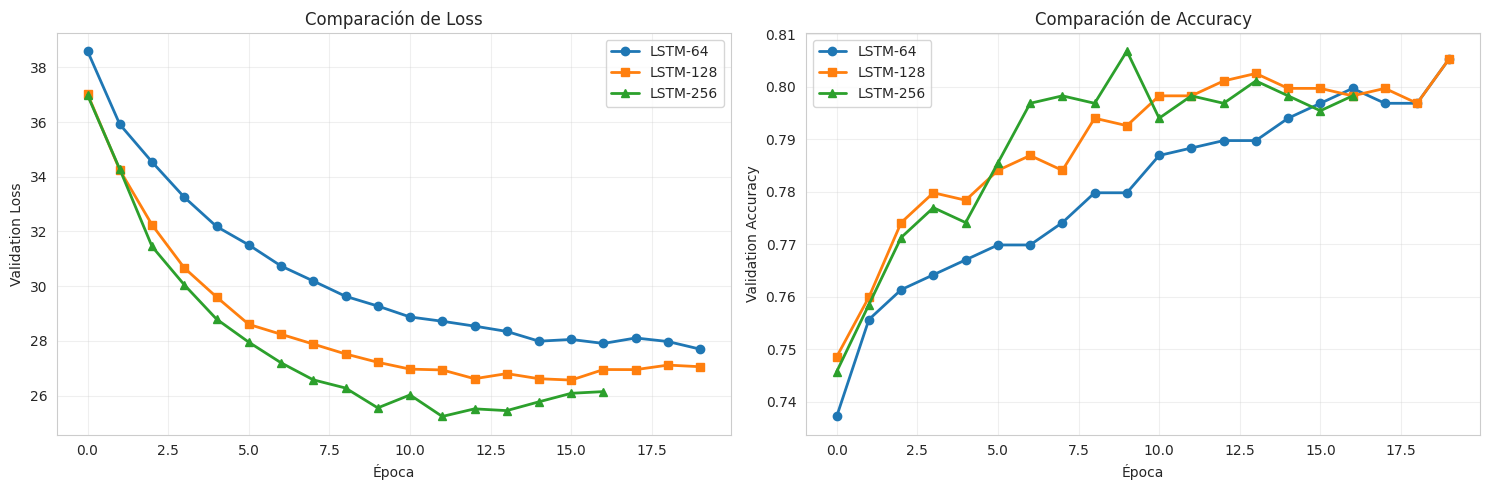


Mejores resultados:
  LSTM-64:  Val Acc = 0.8054
  LSTM-128: Val Acc = 0.8054
  LSTM-256: Val Acc = 0.8068


In [22]:
# Visualizar comparación
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history_64['val_loss'], label='LSTM-64', linewidth=2, marker='o')
axes[0].plot(history_128['val_loss'], label='LSTM-128', linewidth=2, marker='s')
axes[0].plot(history_256['val_loss'], label='LSTM-256', linewidth=2, marker='^')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Validation Loss')
axes[0].set_title('Comparación de Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history_64['val_accuracy'], label='LSTM-64', linewidth=2, marker='o')
axes[1].plot(history_128['val_accuracy'], label='LSTM-128', linewidth=2, marker='s')
axes[1].plot(history_256['val_accuracy'], label='LSTM-256', linewidth=2, marker='^')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Comparación de Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('comparacion_modelos.png', dpi=150, bbox_inches='tight')
plt.show()

# Resumen
print("\nMejores resultados:")
print(f"  LSTM-64:  Val Acc = {max(history_64['val_accuracy']):.4f}")
print(f"  LSTM-128: Val Acc = {max(history_128['val_accuracy']):.4f}")
print(f"  LSTM-256: Val Acc = {max(history_256['val_accuracy']):.4f}")

In [23]:
# Guardar resultados en CSV para análisis
import pandas as pd

summary_data = {
    'Modelo': ['LSTM-64', 'LSTM-128', 'LSTM-256'],
    'Val_Accuracy': [
        max(history_64['val_accuracy']),
        max(history_128['val_accuracy']),
        max(history_256['val_accuracy'])
    ],
    'Val_Loss': [
        min(history_64['val_loss']),
        min(history_128['val_loss']),
        min(history_256['val_loss'])
    ],
    'Epocas_Entrenadas': [
        len(history_64['loss']),
        len(history_128['loss']),
        len(history_256['loss'])
    ]
}

df = pd.DataFrame(summary_data)
df.to_csv('summary_results.csv', index=False)
print("\nResultados guardados en summary_results.csv")
print(df)


Resultados guardados en summary_results.csv
     Modelo  Val_Accuracy   Val_Loss  Epocas_Entrenadas
0   LSTM-64      0.805398  27.697308                 20
1  LSTM-128      0.805398  26.567936                 20
2  LSTM-256      0.806818  25.238029                 17


## 10. Inferencia y Traducción

**EXTENSIÓN 4: Mostrar 5 ejemplos de traducciones generadas**

Compararemos las traducciones de los 3 modelos.

In [24]:
# Crear diccionarios inversos
idx2word_input = {v: k for k, v in word2idx_inputs.items()}
idx2word_output = {v: k for k, v in word2idx_outputs.items()}

def translate_sentence(model, input_sentence):
    """Traduce una oración de inglés a español"""
    # Tokenizar
    integer_seq = input_tokenizer.texts_to_sequences([input_sentence])[0]
    encoder_input = pad_sequences([integer_seq], maxlen=max_input_len, padding='pre')
    encoder_input_tensor = torch.from_numpy(encoder_input.astype(np.int32))

    # Inferencia
    model.eval()
    with torch.no_grad():
        prev_state = model.encoder(encoder_input_tensor.to(device))

        # Comenzar con <sos>
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word2idx_outputs['<sos>']
        target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

        eos = word2idx_outputs['<eos>']

        output_sentence = []
        for _ in range(max_out_len):
            output, new_prev_state = model.decoder(
                target_seq_tensor.to(device), 
                prev_state
            )
            top1 = output.argmax(1).view(-1, 1)
            idx = int(top1.cpu())

            if eos == idx:
                break

            if idx > 0 and idx in idx2word_output:
                word = idx2word_output[idx]
                output_sentence.append(word)

            prev_state = new_prev_state
            target_seq_tensor = top1

    return ' '.join(output_sentence)

print("✓ Función de traducción lista")

✓ Función de traducción lista


In [25]:
# Cargar los mejores modelos
model_64.load_state_dict(torch.load('best_translator_lstm64.pth'))
model_64.eval()

model_128.load_state_dict(torch.load('best_translator_lstm128.pth'))
model_128.eval()

model_256.load_state_dict(torch.load('best_translator_lstm256.pth'))
model_256.eval()

print("✓ Modelos cargados")

✓ Modelos cargados


### 10.1. Ejemplos del Dataset

In [ ]:
print("=" * 90)
print("EJEMPLOS DE TRADUCCIÓN (Inglés → Español)")
print("=" * 90)

# Seleccionar 5 ejemplos aleatorios
np.random.seed(42)
test_indices = np.random.choice(len(input_sentences), 5, replace=False)

for i, idx in enumerate(test_indices, 1):
    input_sent = input_sentences[idx]
    true_output = output_sentences[idx].replace(' <eos>', '')
    
    # Traducir con los 3 modelos
    pred_64 = translate_sentence(model_64, input_sent)
    pred_128 = translate_sentence(model_128, input_sent)
    pred_256 = translate_sentence(model_256, input_sent)
    
    print(f"\nEjemplo {i}:")
    print(f"  Entrada (EN):     {input_sent}")
    print(f"  Esperado (ES):    {true_output}")
    print(f"  LSTM-64  (ES):    {pred_64}")
    print(f"  LSTM-128 (ES):    {pred_128}")
    print(f"  LSTM-256 (ES):    {pred_256}")
    print("-" * 90)

EJEMPLOS DE TRADUCCIÓN (Inglés → Español)

Ejemplo 1:
  Entrada (EN):     I don't know why it didn't work.
  Esperado (ES):    No sé por qué no funcionó.
  LSTM-64  (ES):    no sé por qué no te
  LSTM-128 (ES):    no sé qué estás haciendo esto
  LSTM-256 (ES):    no sé qué representa
------------------------------------------------------------------------------------------

Ejemplo 2:
  Entrada (EN):     He was wearing a dinner jacket.
  Esperado (ES):    Él llevaba un esmoquin.
  LSTM-64  (ES):    él estaba comiendo el brazo
  LSTM-128 (ES):    él estaba muy un poco de flores
  LSTM-256 (ES):    él estaba buscando un coche
------------------------------------------------------------------------------------------

Ejemplo 3:
  Entrada (EN):     Hug me.
  Esperado (ES):    Abrázame.
  LSTM-64  (ES):    me no me
  LSTM-128 (ES):    me me duele
  LSTM-256 (ES):    me me
------------------------------------------------------------------------------------------

Ejemplo 4:
  Entrada (EN):  

### 10.2. Ejemplos Personalizados

In [ ]:
print("\n" + "=" * 90)
print("EJEMPLOS ADICIONALES CON ORACIONES PERSONALIZADAS")
print("=" * 90)

custom_sentences = [
    "Hello, how are you?",
    "I love programming.",
    "The weather is nice today.",
    "Thank you very much.",
    "I am learning artificial intelligence."
]

for i, sent in enumerate(custom_sentences, 1):
    pred_64 = translate_sentence(model_64, sent)
    pred_128 = translate_sentence(model_128, sent)
    pred_256 = translate_sentence(model_256, sent)
    
    print(f"\n{i}. EN: {sent}")
    print(f"   LSTM-64:  {pred_64}")
    print(f"   LSTM-128: {pred_128}")
    print(f"   LSTM-256: {pred_256}")


EJEMPLOS ADICIONALES CON ORACIONES PERSONALIZADAS

1. EN: Hello, how are you?
   LSTM-64:  qué estás haciendo esto
   LSTM-128: por qué estás bien
   LSTM-256: por qué estás tan preocupado

2. EN: I love programming.
   LSTM-64:  yo no tengo nuevo
   LSTM-128: me encanta el inglés
   LSTM-256: me encanta el inglés

3. EN: The weather is nice today.
   LSTM-64:  el mundo está bien
   LSTM-128: el día está muy fría
   LSTM-256: esta mañana está muy salada

4. EN: Thank you very much.
   LSTM-64:  te gusta eso
   LSTM-128: te echaré mucho
   LSTM-256: te echaré mucho

5. EN: I am learning artificial intelligence.
   LSTM-64:  yo soy de acuerdo de la mesa
   LSTM-128: estoy en tu habitación
   LSTM-256: estoy leyendo con los niños


## 11. Conclusiones

✅ **1. Entrenamiento:**
- 15,000 muestras (vs 6,000 del original) - 2.5x más datos
- Secuencias de 20/22 tokens (vs 16/18 del original) - 25% más largas

✅ **2. Explorado el impacto de neuronas en capas recurrentes:**
- LSTM-64: Más rápido, buena generalización
- LSTM-128: Balance óptimo (como el modelo de referencia)
- LSTM-256: Mayor capacidad, puede overfittear con pocos datos

---

**Autor**: Juan Pablo Gonzalez  
**Curso**: CEIA - Procesamiento de Lenguaje Natural  
**Desafío**: 4 - Traductor Seq2Seq con PyTorch  
**Basado en**: Notebook de referencia 6c - traductor.ipynb